# Store Sales - Time Series Forecasting

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [16]:
train = pd.read_csv('train.csv')

## ARIMA

In this section, we go through fitting an ARIMA model on a time series for one of the families of products in one store; to see how well it performs. 

We are now going to create a dataset for the sales of <b> Bread/Bakery </b> in <b> store 44 </b>.

In [125]:
df = train.loc[(train.store_nbr == 44) & (train.family == 'BREAD/BAKERY')]

Now, we are going to split the data into a training set and a test set, where the training set has all of the sales' data except for the last 16 days, and the test set has the sales' data for the last 16 days:

In [126]:
split_point = df.shape[0] - 16
df_train = df.iloc[:split_point, :]
df_test = df.iloc[split_point:, :]
df_train.reset_index(inplace=True)

We now visualize the training data and the test data: 

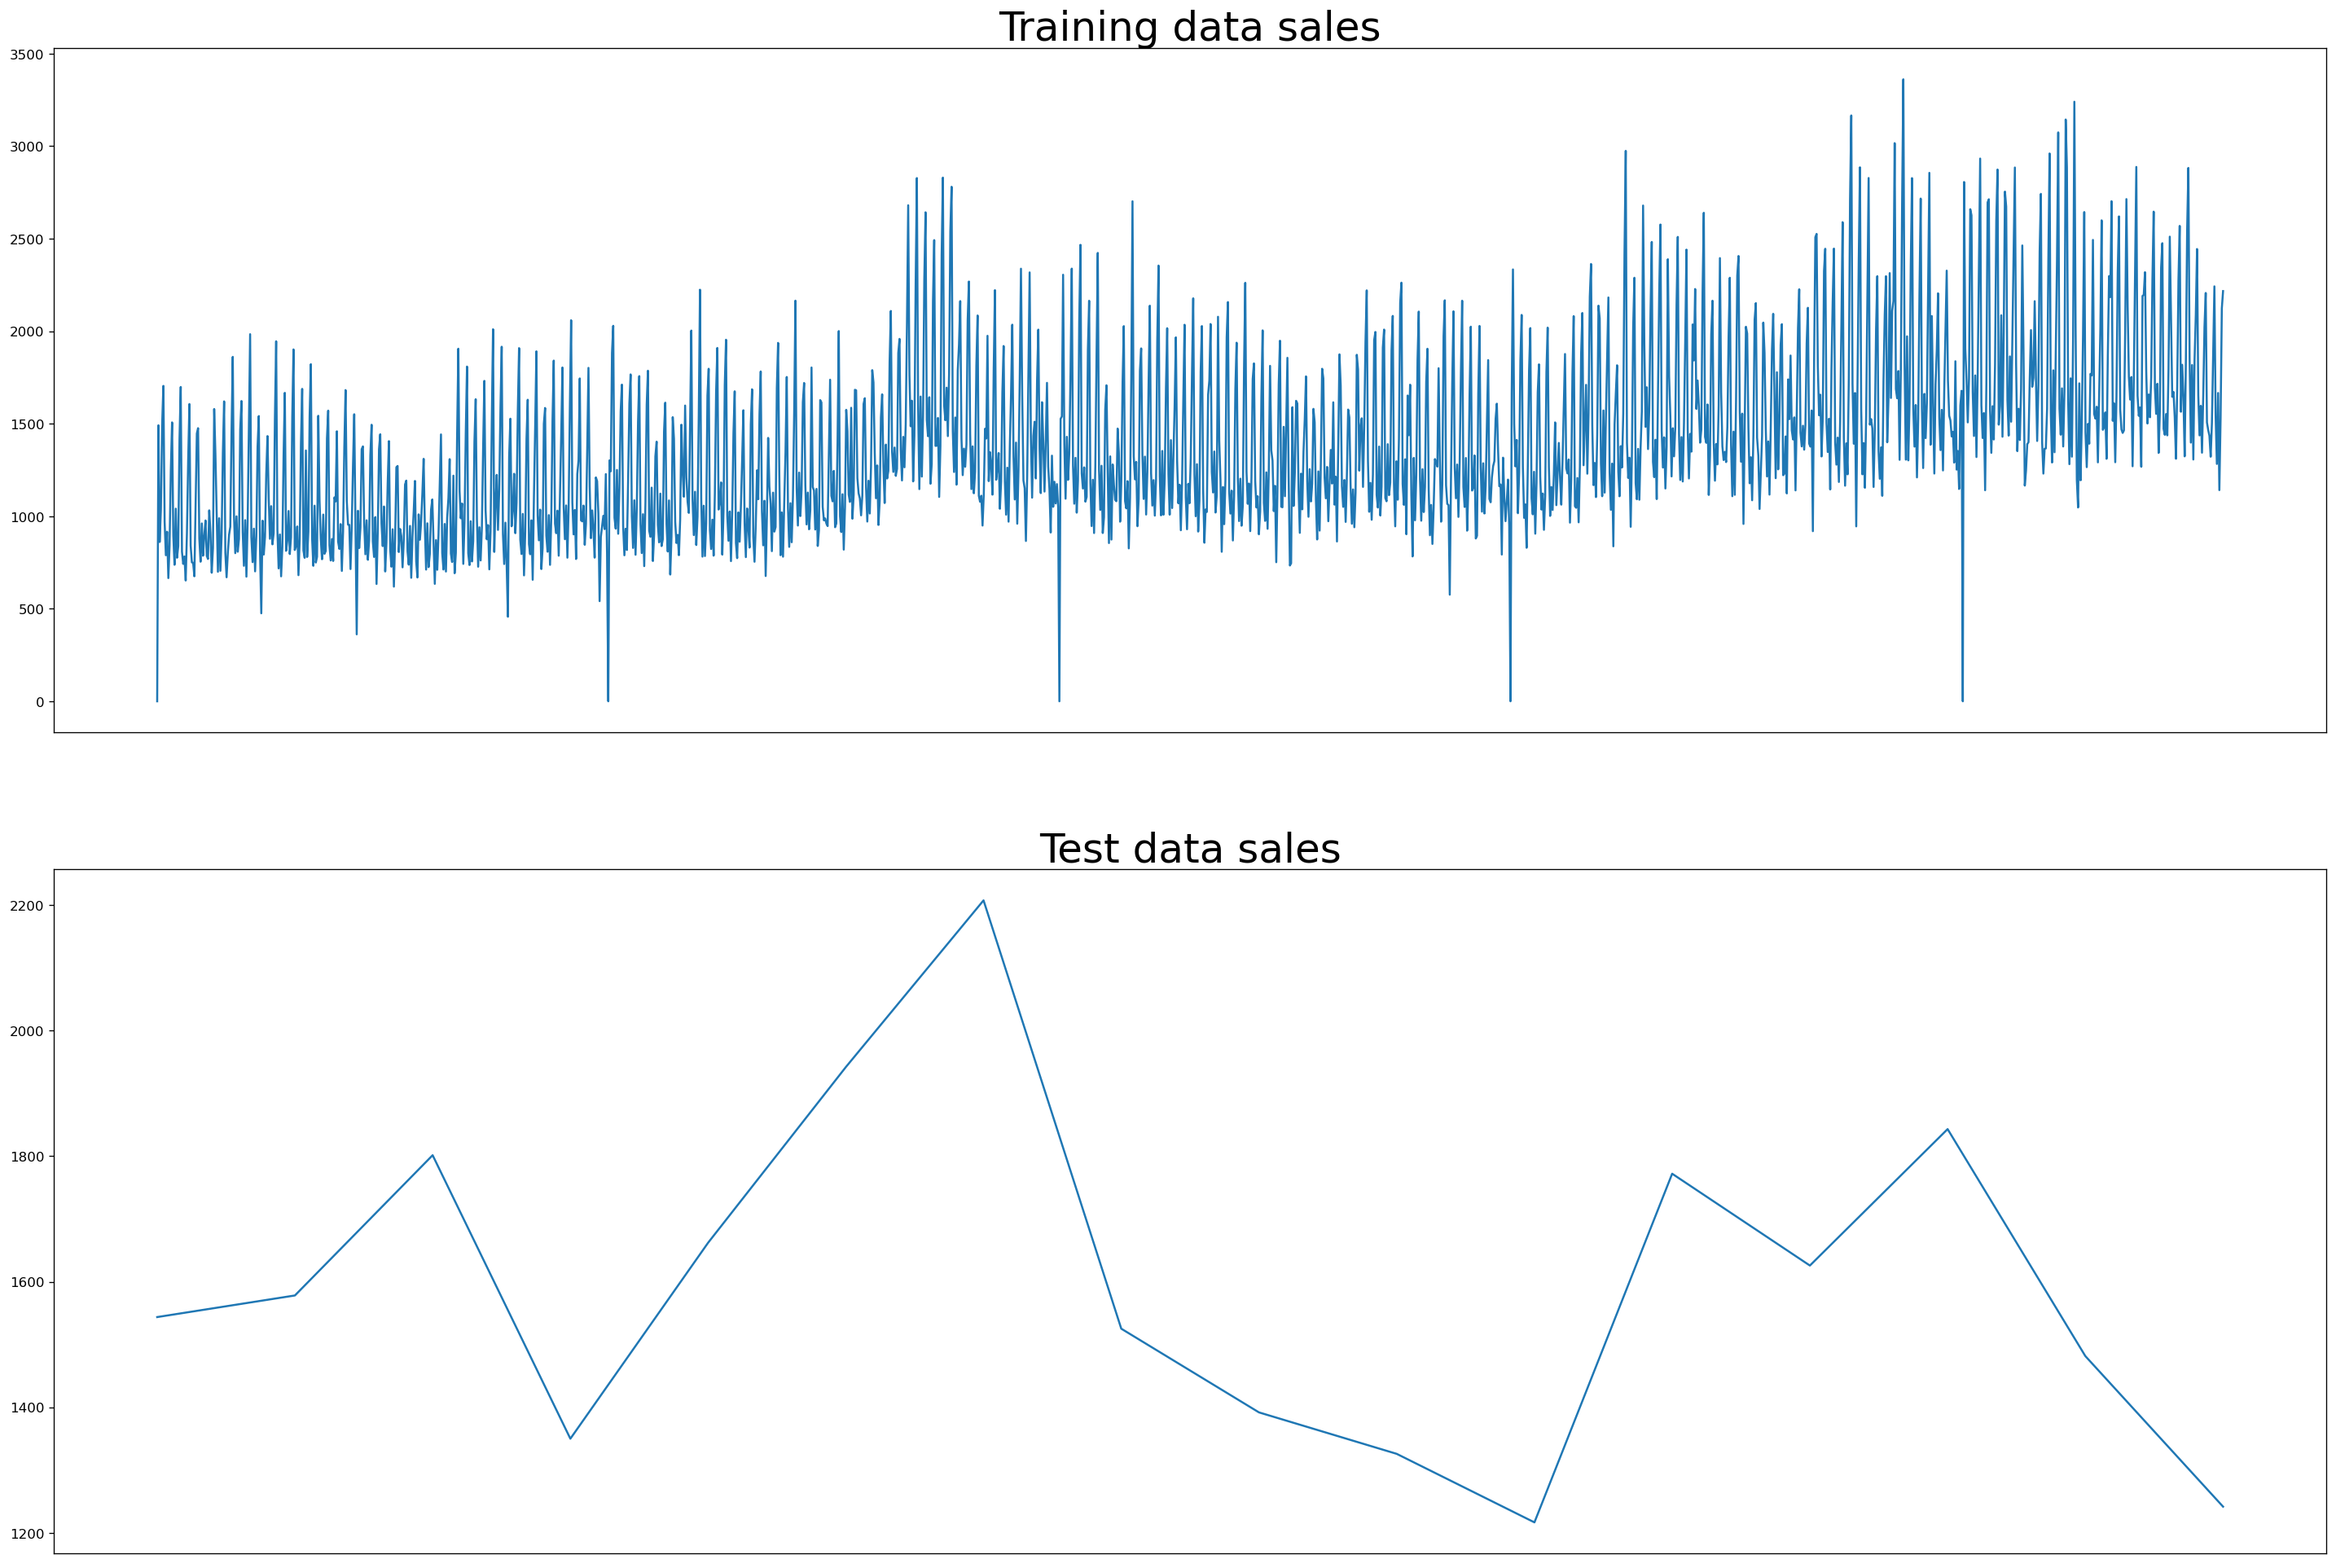

In [144]:
plt.rcParams.update({'figure.figsize':(30,20), 'figure.dpi':120})
fig, ax = plt.subplots(2,1)
ax[0].plot(df_train['date'],df_train['sales'])
ax[0].set_title('Training data sales', fontdict={'fontsize':30})
ax[1].plot(df_test['date'], df_test['sales'])
ax[1].set_title('Test data sales', fontdict={'fontsize':30})
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
plt.show()

One very important feature to fit an ARIMA model on our data is for the data to be stationary. From the plot above, it is clear that it is not stationary as the mean is increasing with time. We'll test this with a hypothesis test called ADF (Augmented Dickey-Fuller) as well to back this claim:

<b> NOTE: </b> The null hypothesis of the ADF test is that the time series is non-stationary. 

In [145]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_train.sales)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.176643
p-value: 0.214832


We have a p value of 0.214832, So we do not reject the null hypothesis and so the series is in fact as we claimed non-stationary. In order to solve that, we are going to difference our data.

Let us now plot the original timeseries, as well as the 1st and 2nd order differenced time series with their ACF (Autocorrelation) plots to determine the order of differencing we are going to use in our model:

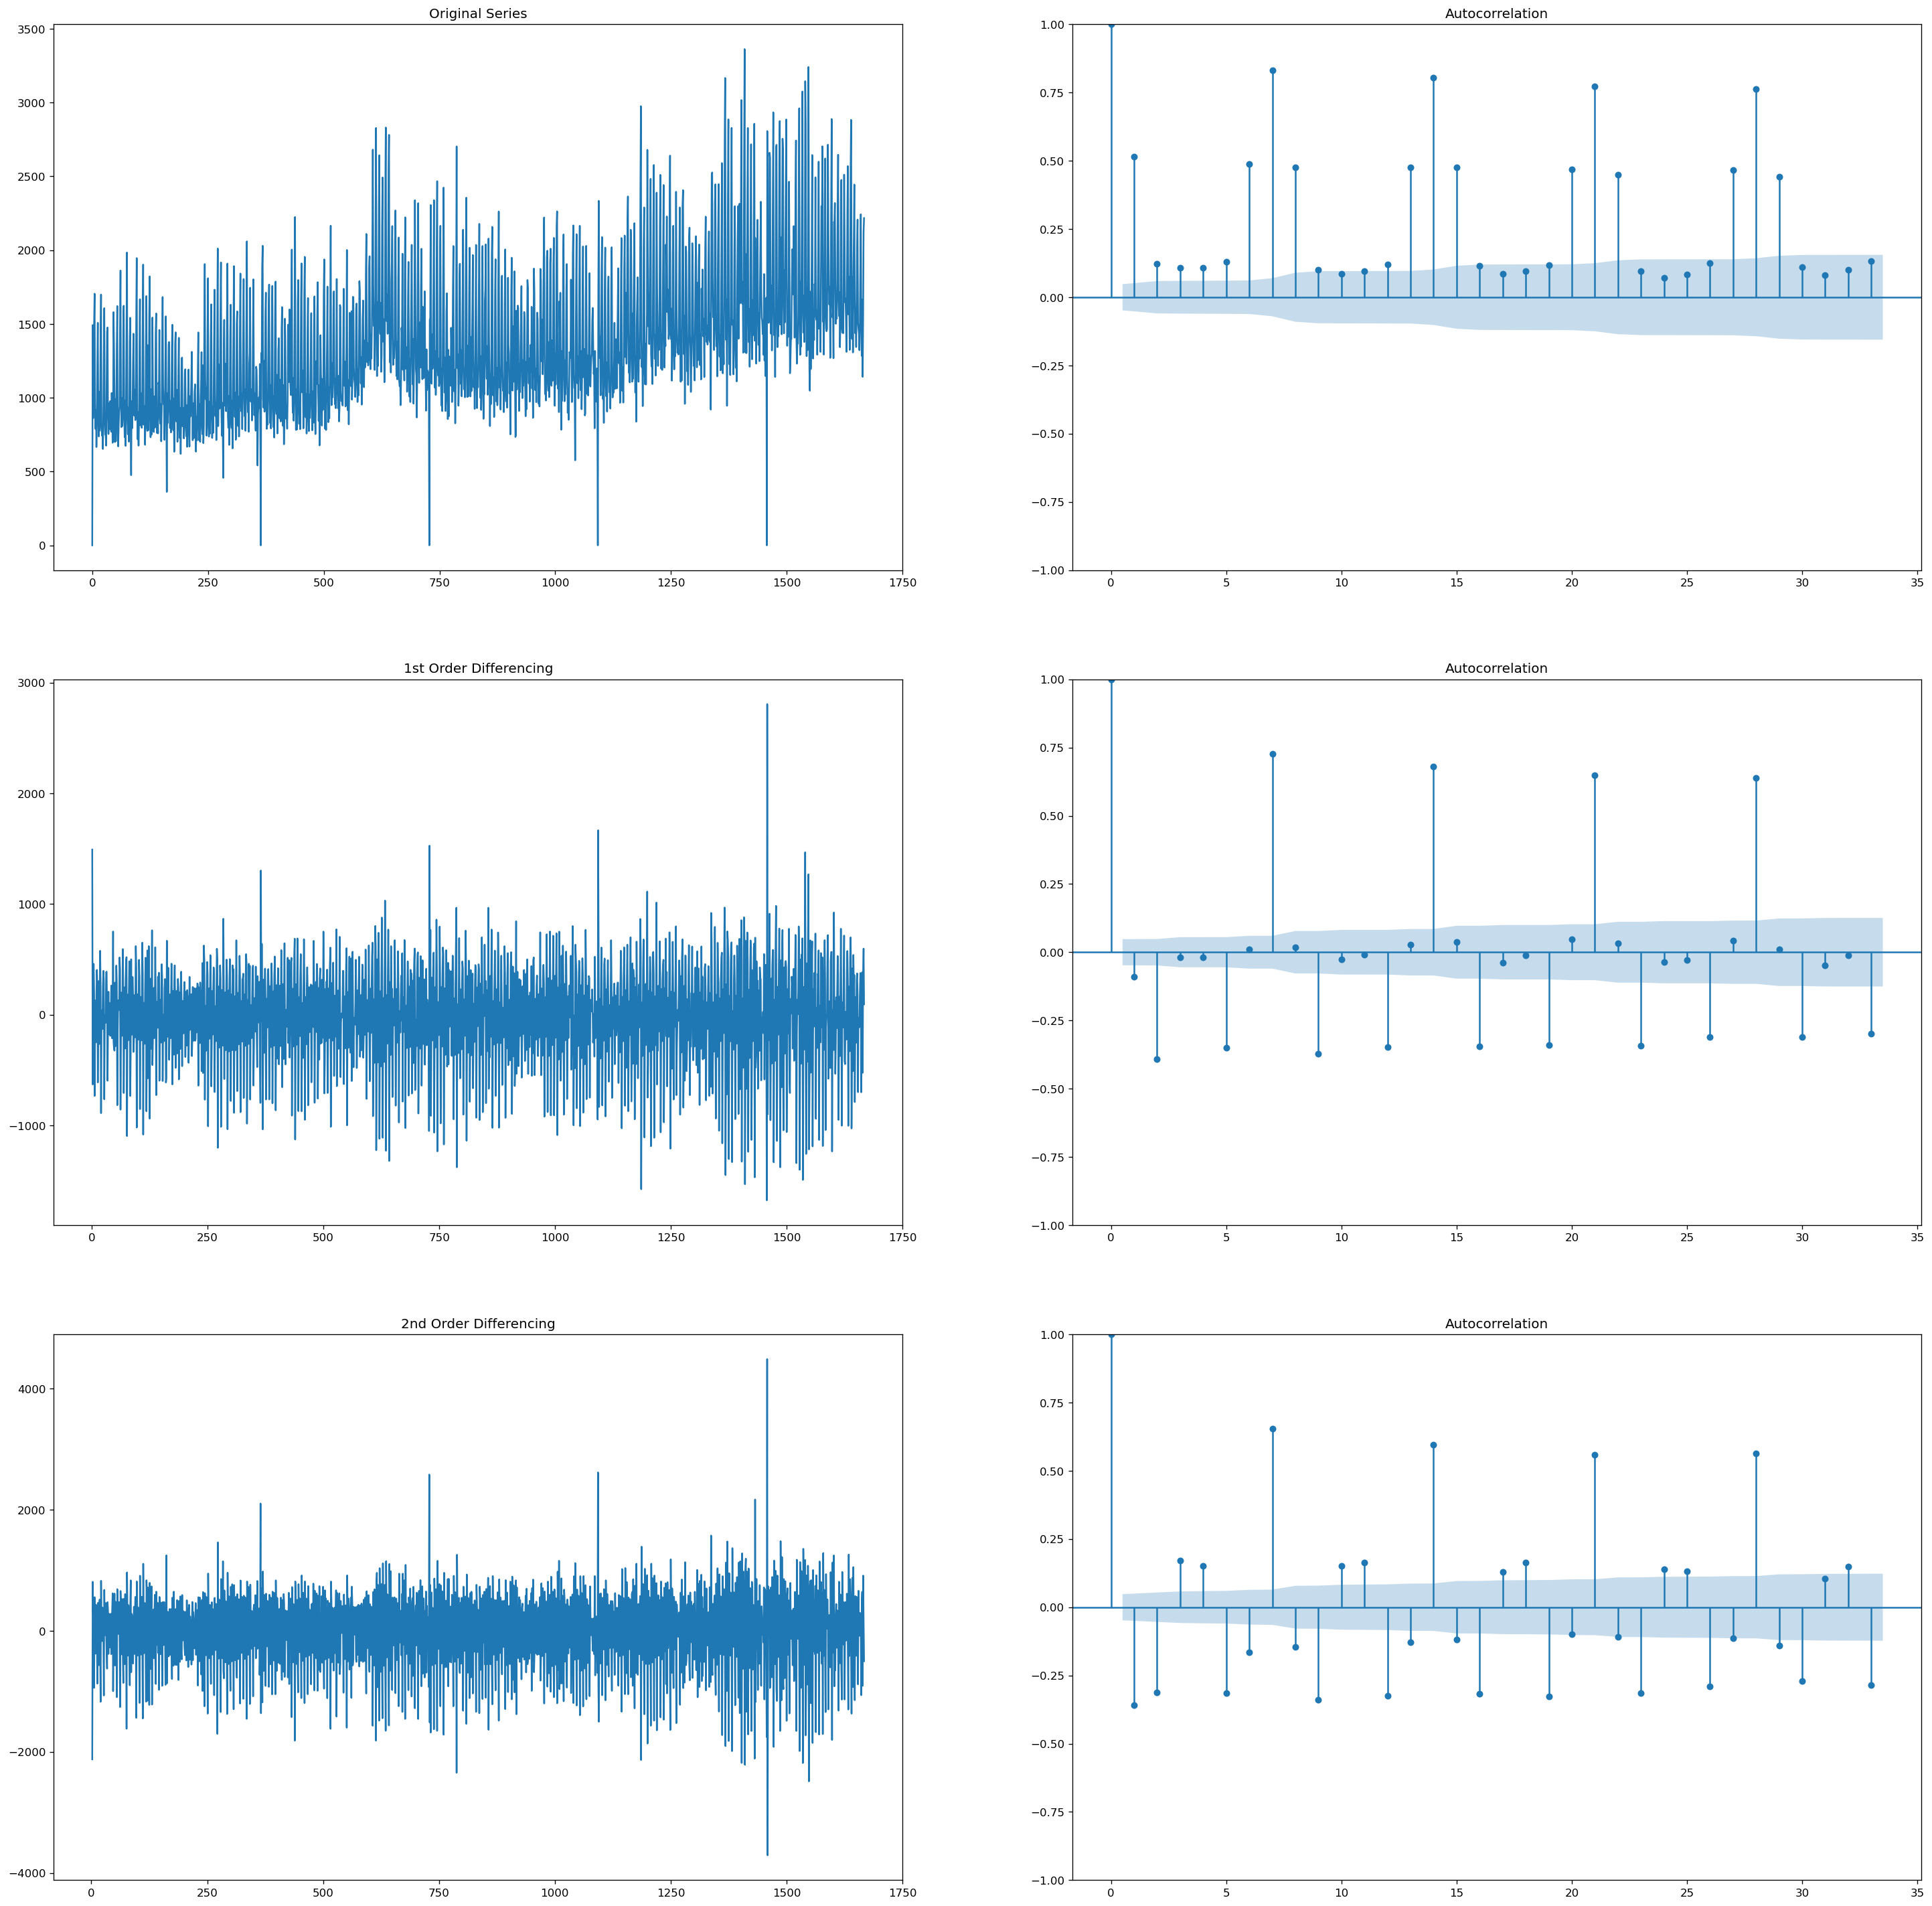

In [152]:
plt.rcParams.update({'figure.figsize':(30,30), 'figure.dpi':120})

fig, ax = plt.subplots(3,2)
ax[0, 0].plot(df_train.sales); ax[0, 0].set_title('Original Series')
plot_acf(df_train.sales, ax=ax[0, 1])

ax[1, 0].plot(df_train.sales.diff()); ax[1, 0].set_title('1st Order Differencing')
plot_acf(df_train.sales.diff().dropna(), ax=ax[1, 1])

ax[2, 0].plot(df_train.sales.diff().diff()); ax[2, 0].set_title('2nd Order Differencing')
plot_acf(df_train.sales.diff().diff().dropna(), ax=ax[2, 1])



The ACF plot for the original data is a bit worrying; all of the lags have large (significant) positive values which indicate that the data needs differencing. The 1st order differenced plot looks better, and even though the ACF plot is still not very promising, it is a bit more reasonable. We test again with the ADF:

In [159]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_train.sales.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.552868
p-value: 0.000000


Great, the test concludes that the 1st order differenced time series is stationary. Thus, we choose to proceed with the 1st order differenced data instead of the original data.

- - -- - - - -

We now move on to identifying the number of AR terms (p) and the number of MA terms (q) that we are going to include in our ARIMA model. We do this by inspecting the ACF and PACF plots for the data.

Starting off, let us plot the ACF to determine the number of MA terms (q) to include in the model:

In [131]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

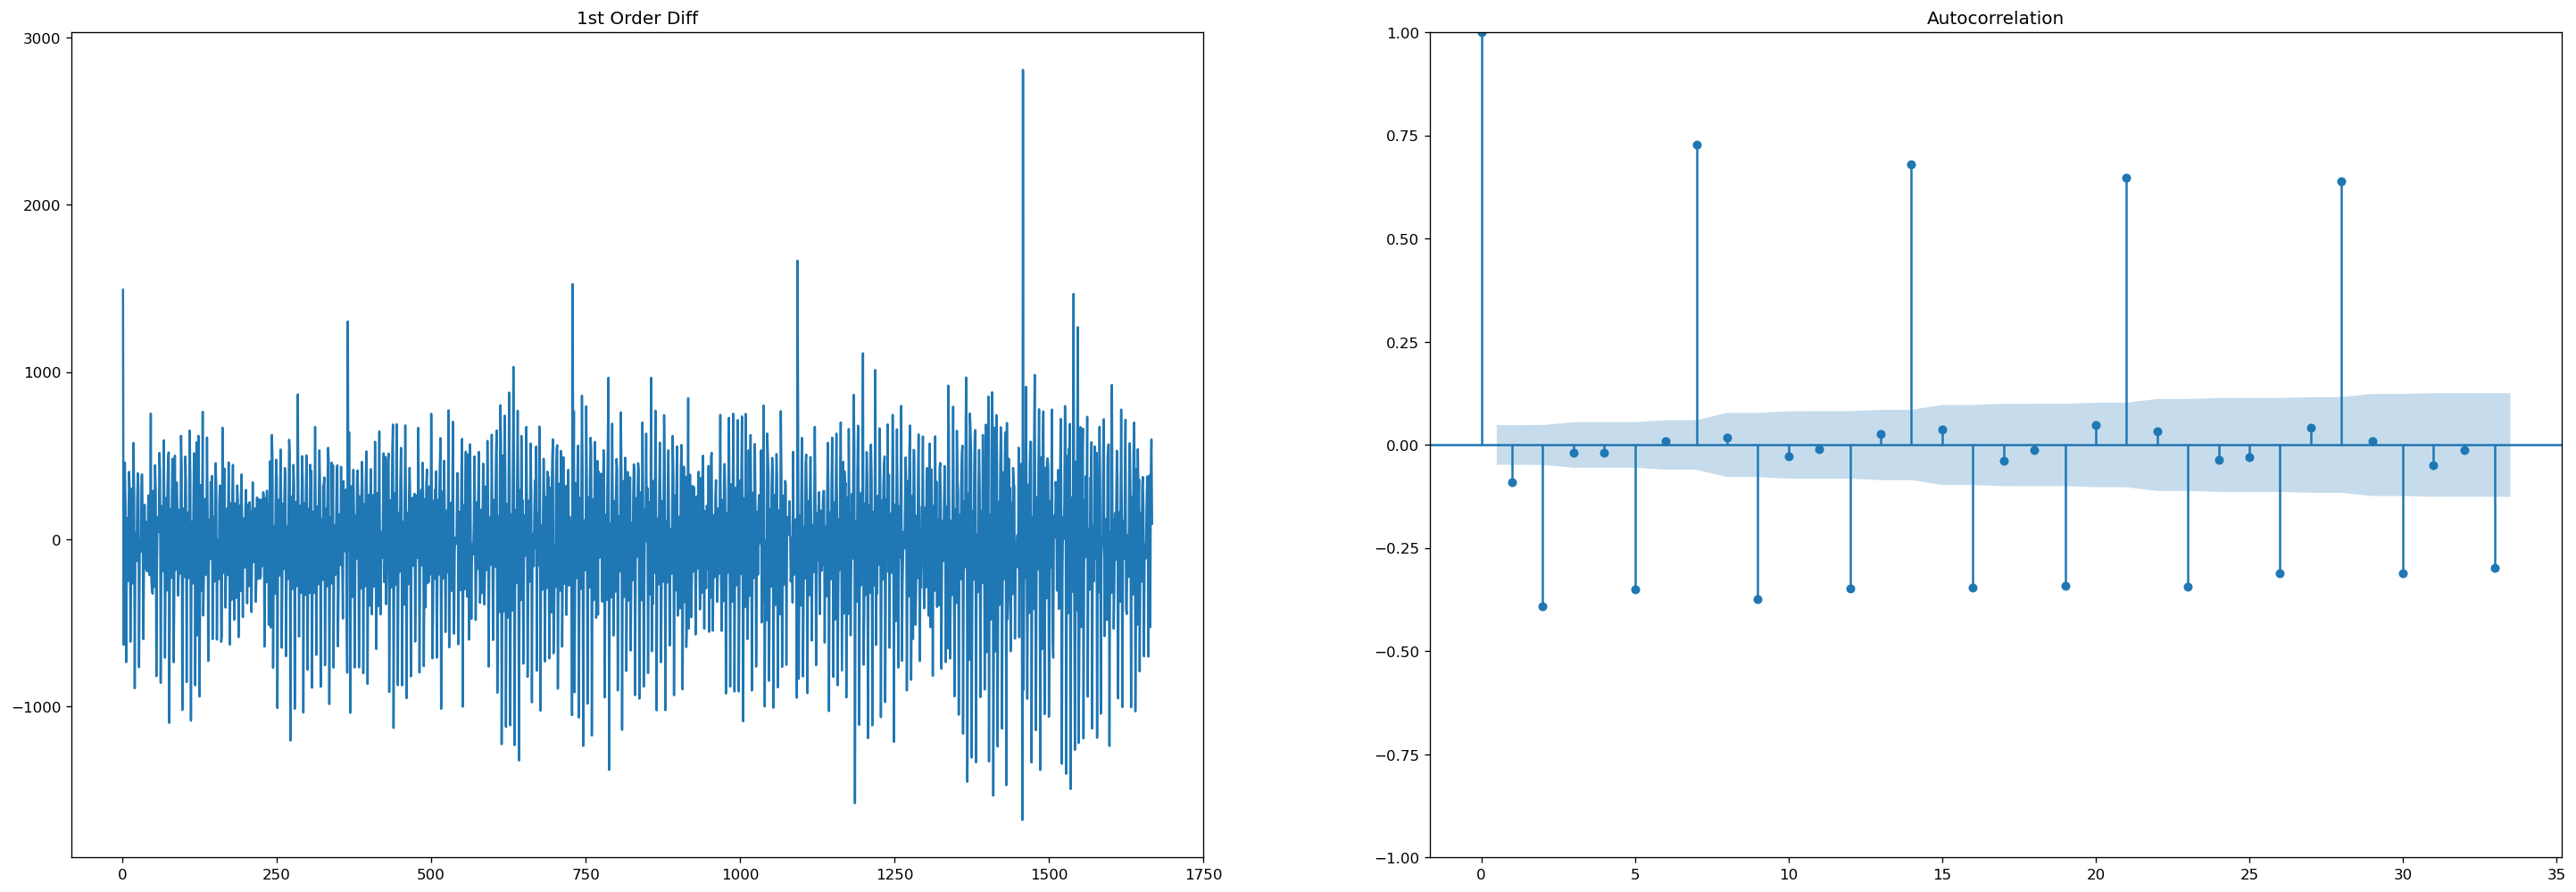

In [151]:
plt.rcParams.update({'figure.figsize':(30,10), 'figure.dpi':120})

fig, ax = plt.subplots(1, 2)
ax[0].plot(df_train.sales.diff()); ax[0].set_title('1st Order Diff')
plot_acf(df_train.sales.diff().dropna(), ax=ax[1])

We let q=2.

Now, let us plot the PACF to determine the number of AR (p) terms: 

/Users/amrsameh/miniconda3/envs/pyds/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


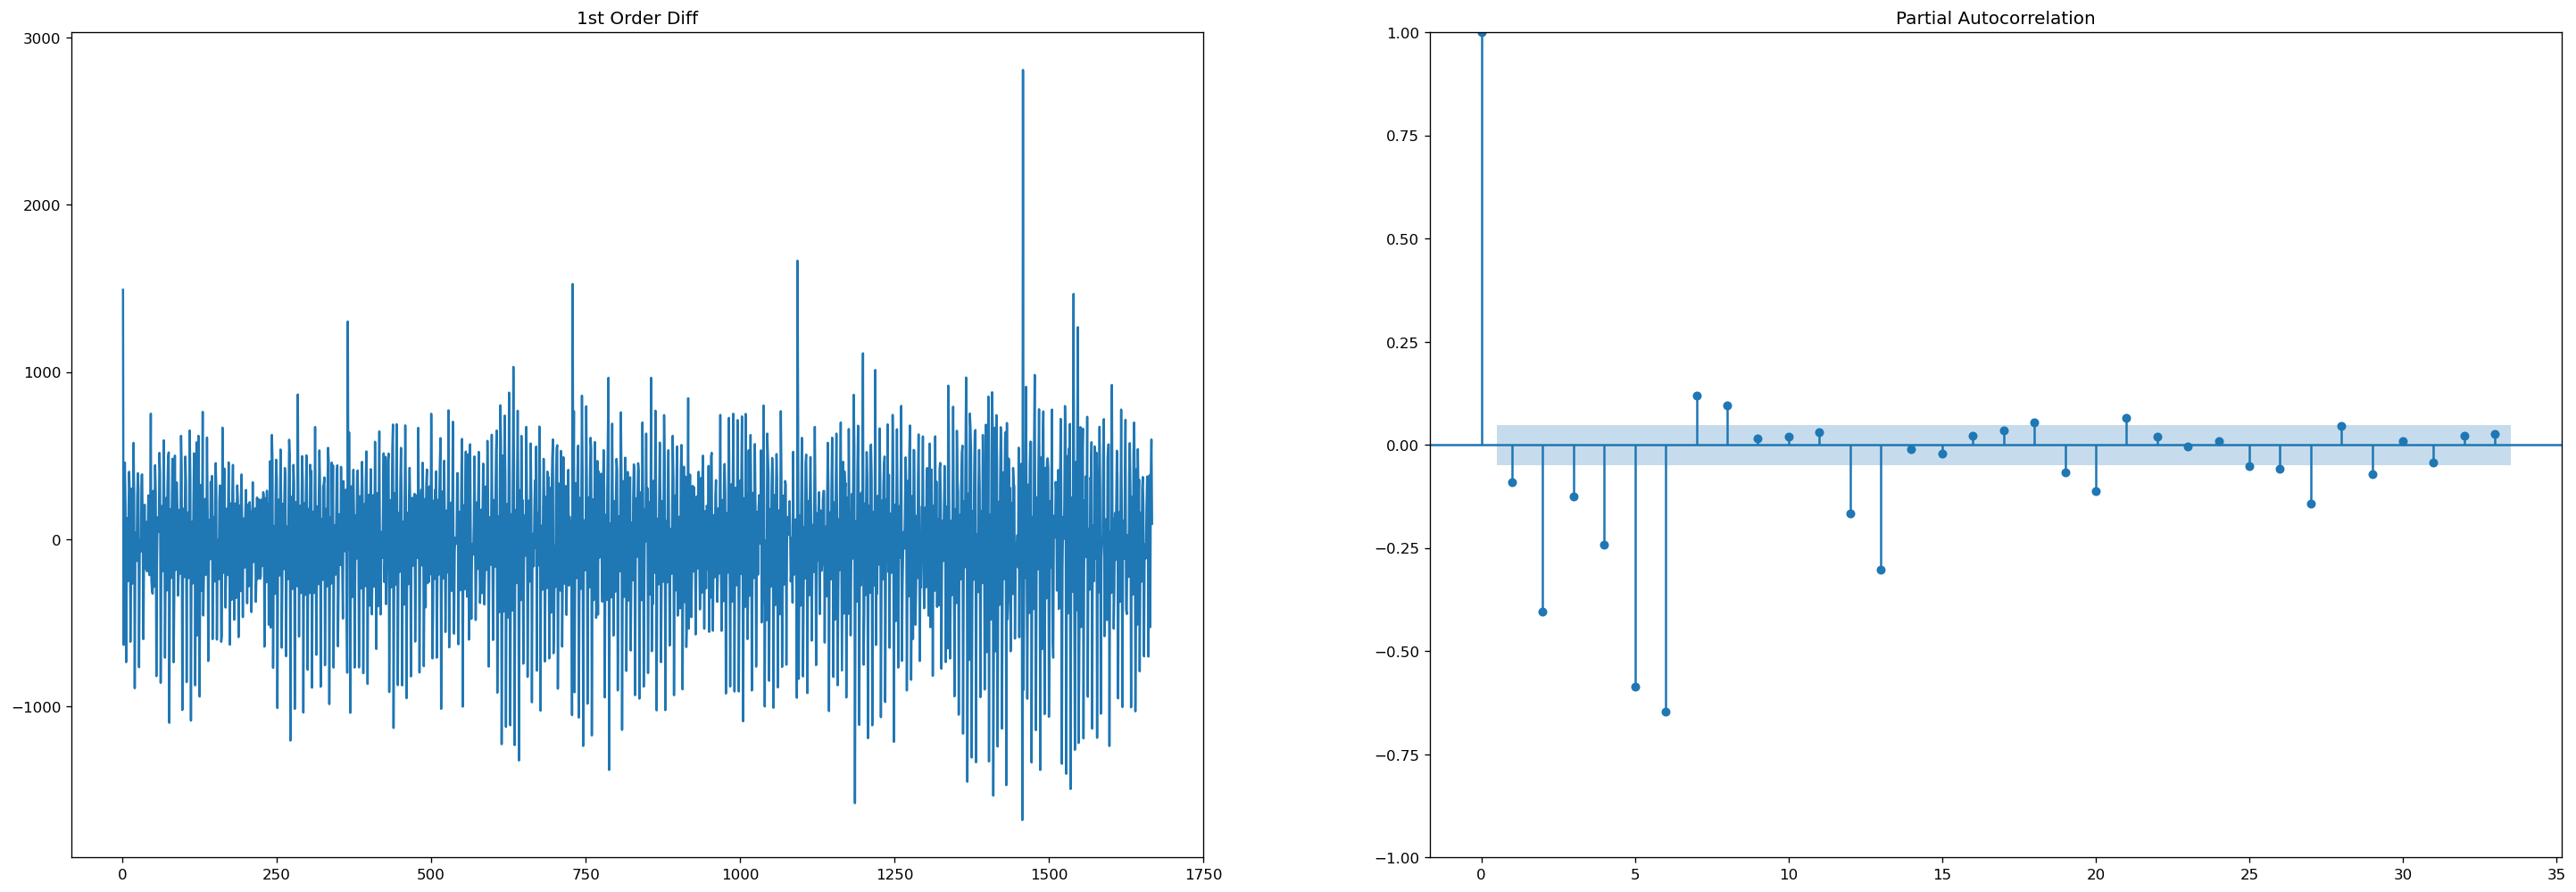

In [133]:
plt.rcParams.update({'figure.figsize':(30,10), 'figure.dpi':120})

fig, ax = plt.subplots(1, 2)
ax[0].plot(df_train.sales.diff()); ax[0].set_title('1st Order Diff')
plot_pacf(df_train.sales.diff().dropna(), ax=ax[1])

We let p=6.

Now, let us fit the ARIMA model:

In [160]:
import statsmodels.api as sm
# 6,1,2 ARIMA Model
model = sm.tsa.arima.ARIMA(df_train.sales, order=(6,1,2)) #p,d,q
model_fit = model.fit()
print(model_fit.summary())

/Users/amrsameh/miniconda3/envs/pyds/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/amrsameh/miniconda3/envs/pyds/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1668
Model:                 ARIMA(6, 1, 2)   Log Likelihood              -11569.622
Date:                Wed, 19 Jan 2022   AIC                          23157.244
Time:                        22:23:25   BIC                          23206.013
Sample:                             0   HQIC                         23175.317
                               - 1668                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7652      0.024    -32.370      0.000      -0.812      -0.719
ar.L2         -0.9116      0.019    -48.697      0.000      -0.948      -0.875
ar.L3         -0.8180      0.022    -37.508      0.0

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance along time).

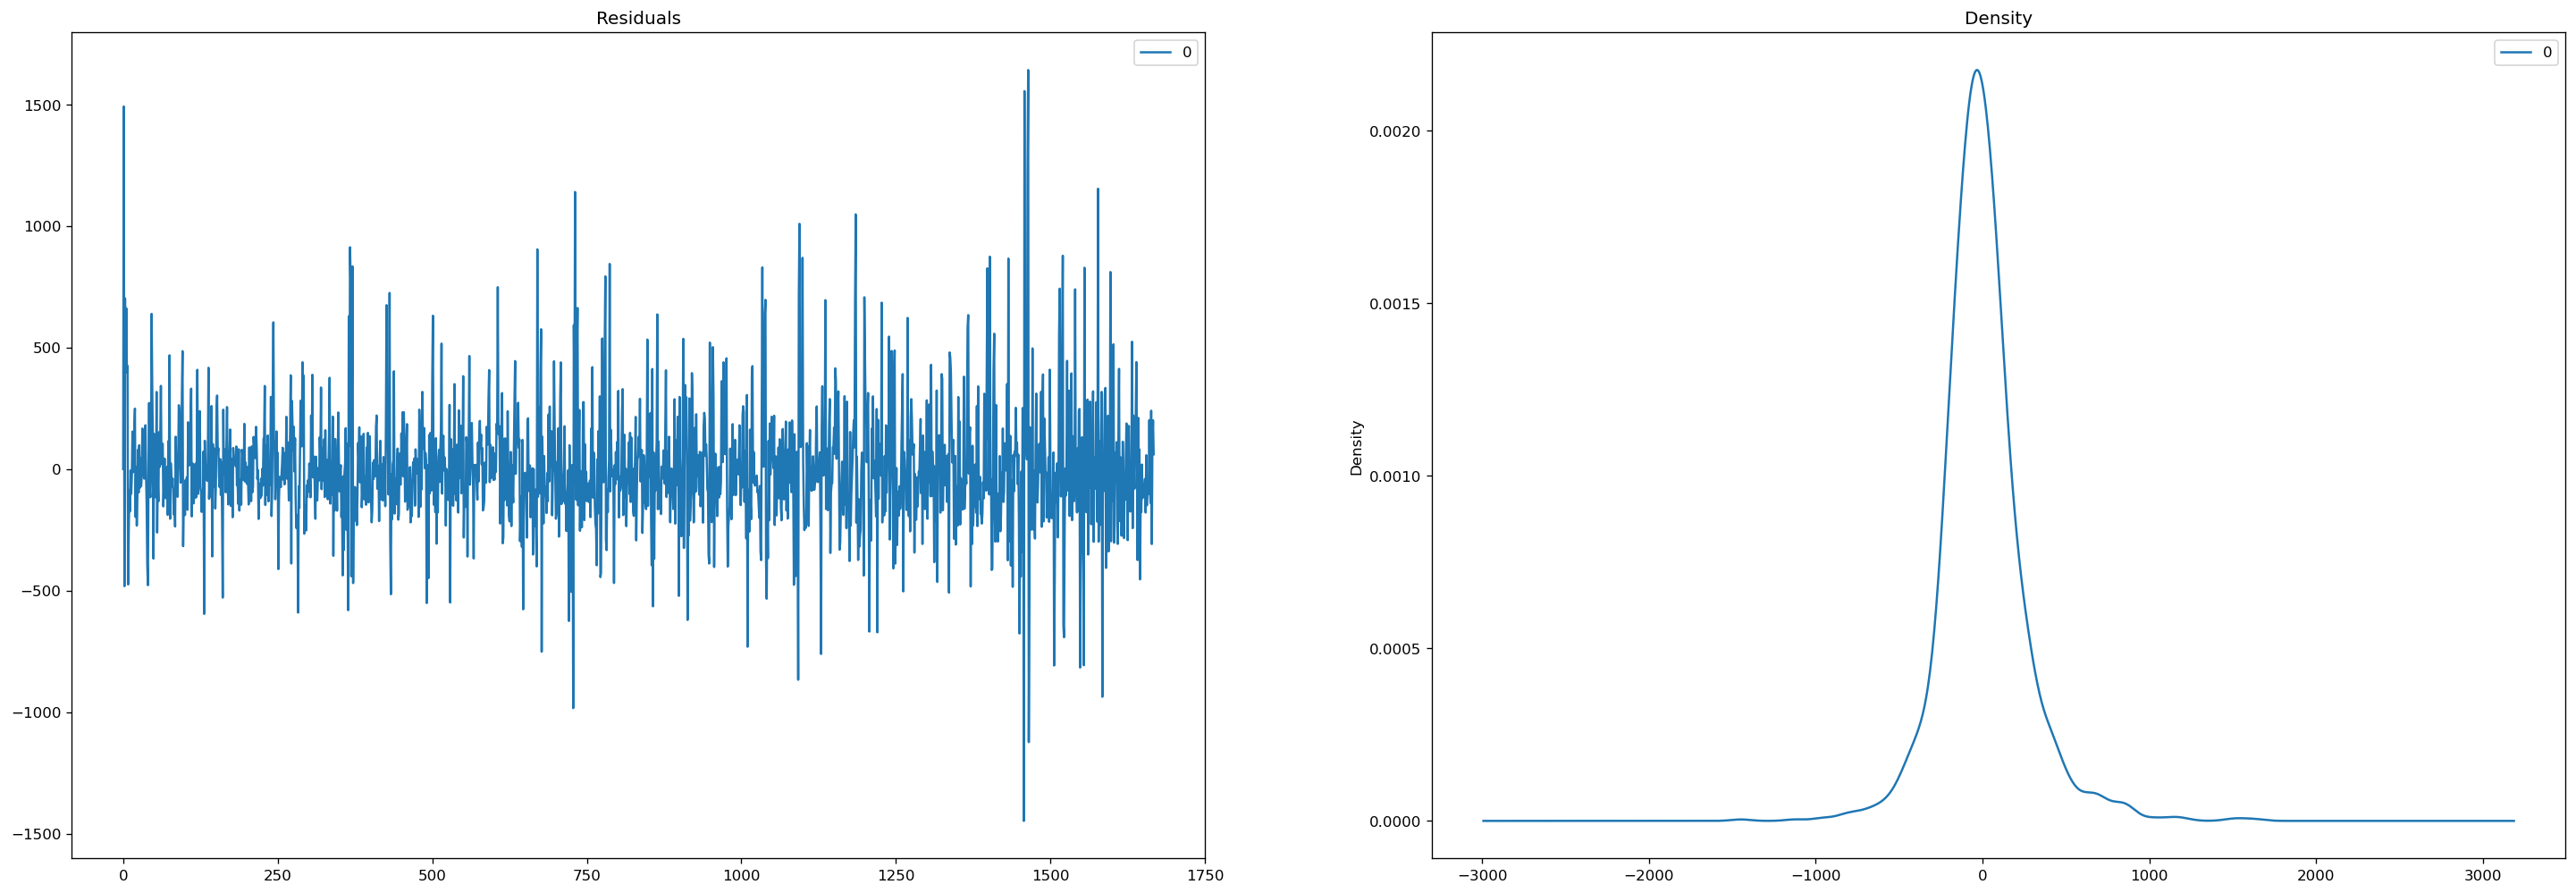

In [162]:
plt.rcParams.update({'figure.figsize':(30,10), 'figure.dpi':120})

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The mean seems to be concentrated around the 0. The variance though varies a bit through time, which is not ideal.

Nonetheless, we proceed and see what we get:

Let us take a look at the original data, as well as the fitted data:

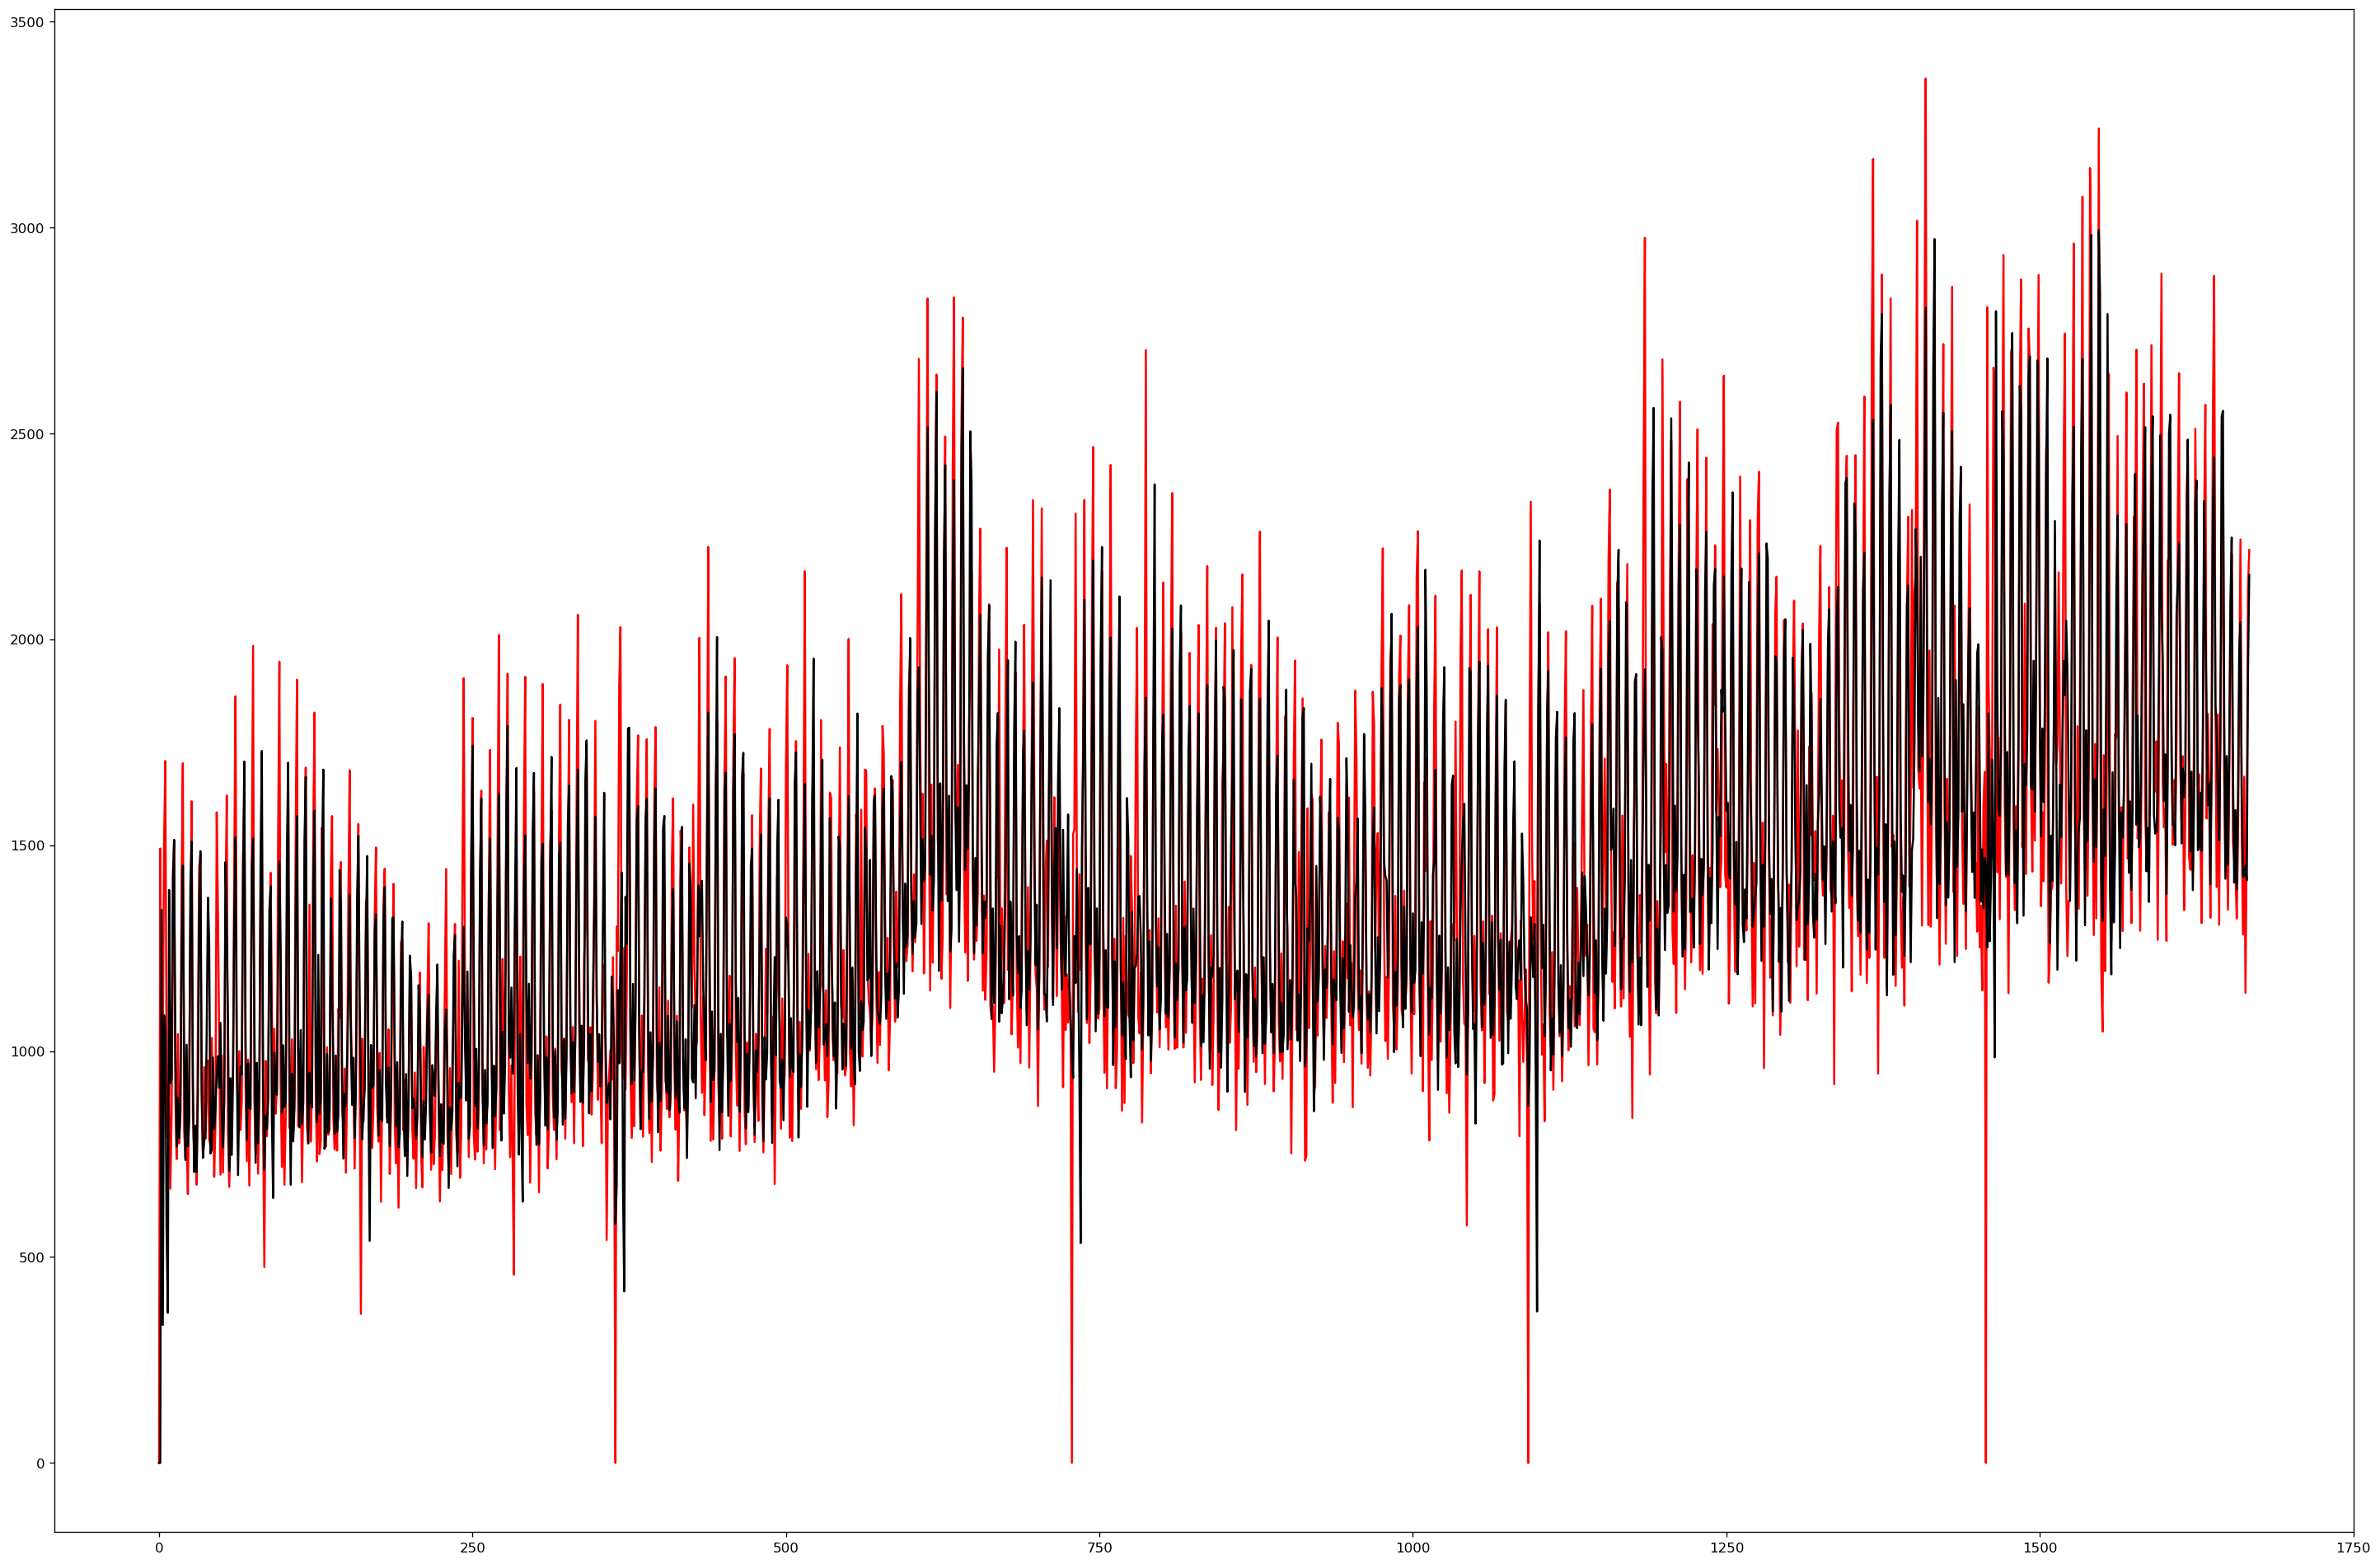

In [163]:
plt.rcParams.update({'figure.figsize':(30,20), 'figure.dpi':120})

plt.plot(df_train.sales, c='red')
plt.plot(model_fit.predict(), c='black')
plt.show()

Not too bad!

Now, let us try predicting the sales for the test data using the model, and compare the predicted results with the true results:

In [164]:
model_fit.forecast(steps=21)

1668    1590.606095
1669    1368.576843
1670    1585.697614
1671    1293.504798
1672    1520.685859
1673    2077.362035
1674    2122.952673
1675    1601.154701
1676    1416.142374
1677    1554.624161
1678    1384.172599
1679    1542.718814
1680    2020.295765
1681    2050.366086
1682    1610.776805
1683    1448.937186
1684    1545.747722
1685    1444.813126
1686    1569.831457
1687    1966.605978
1688    1990.187341
Name: predicted_mean, dtype: float64

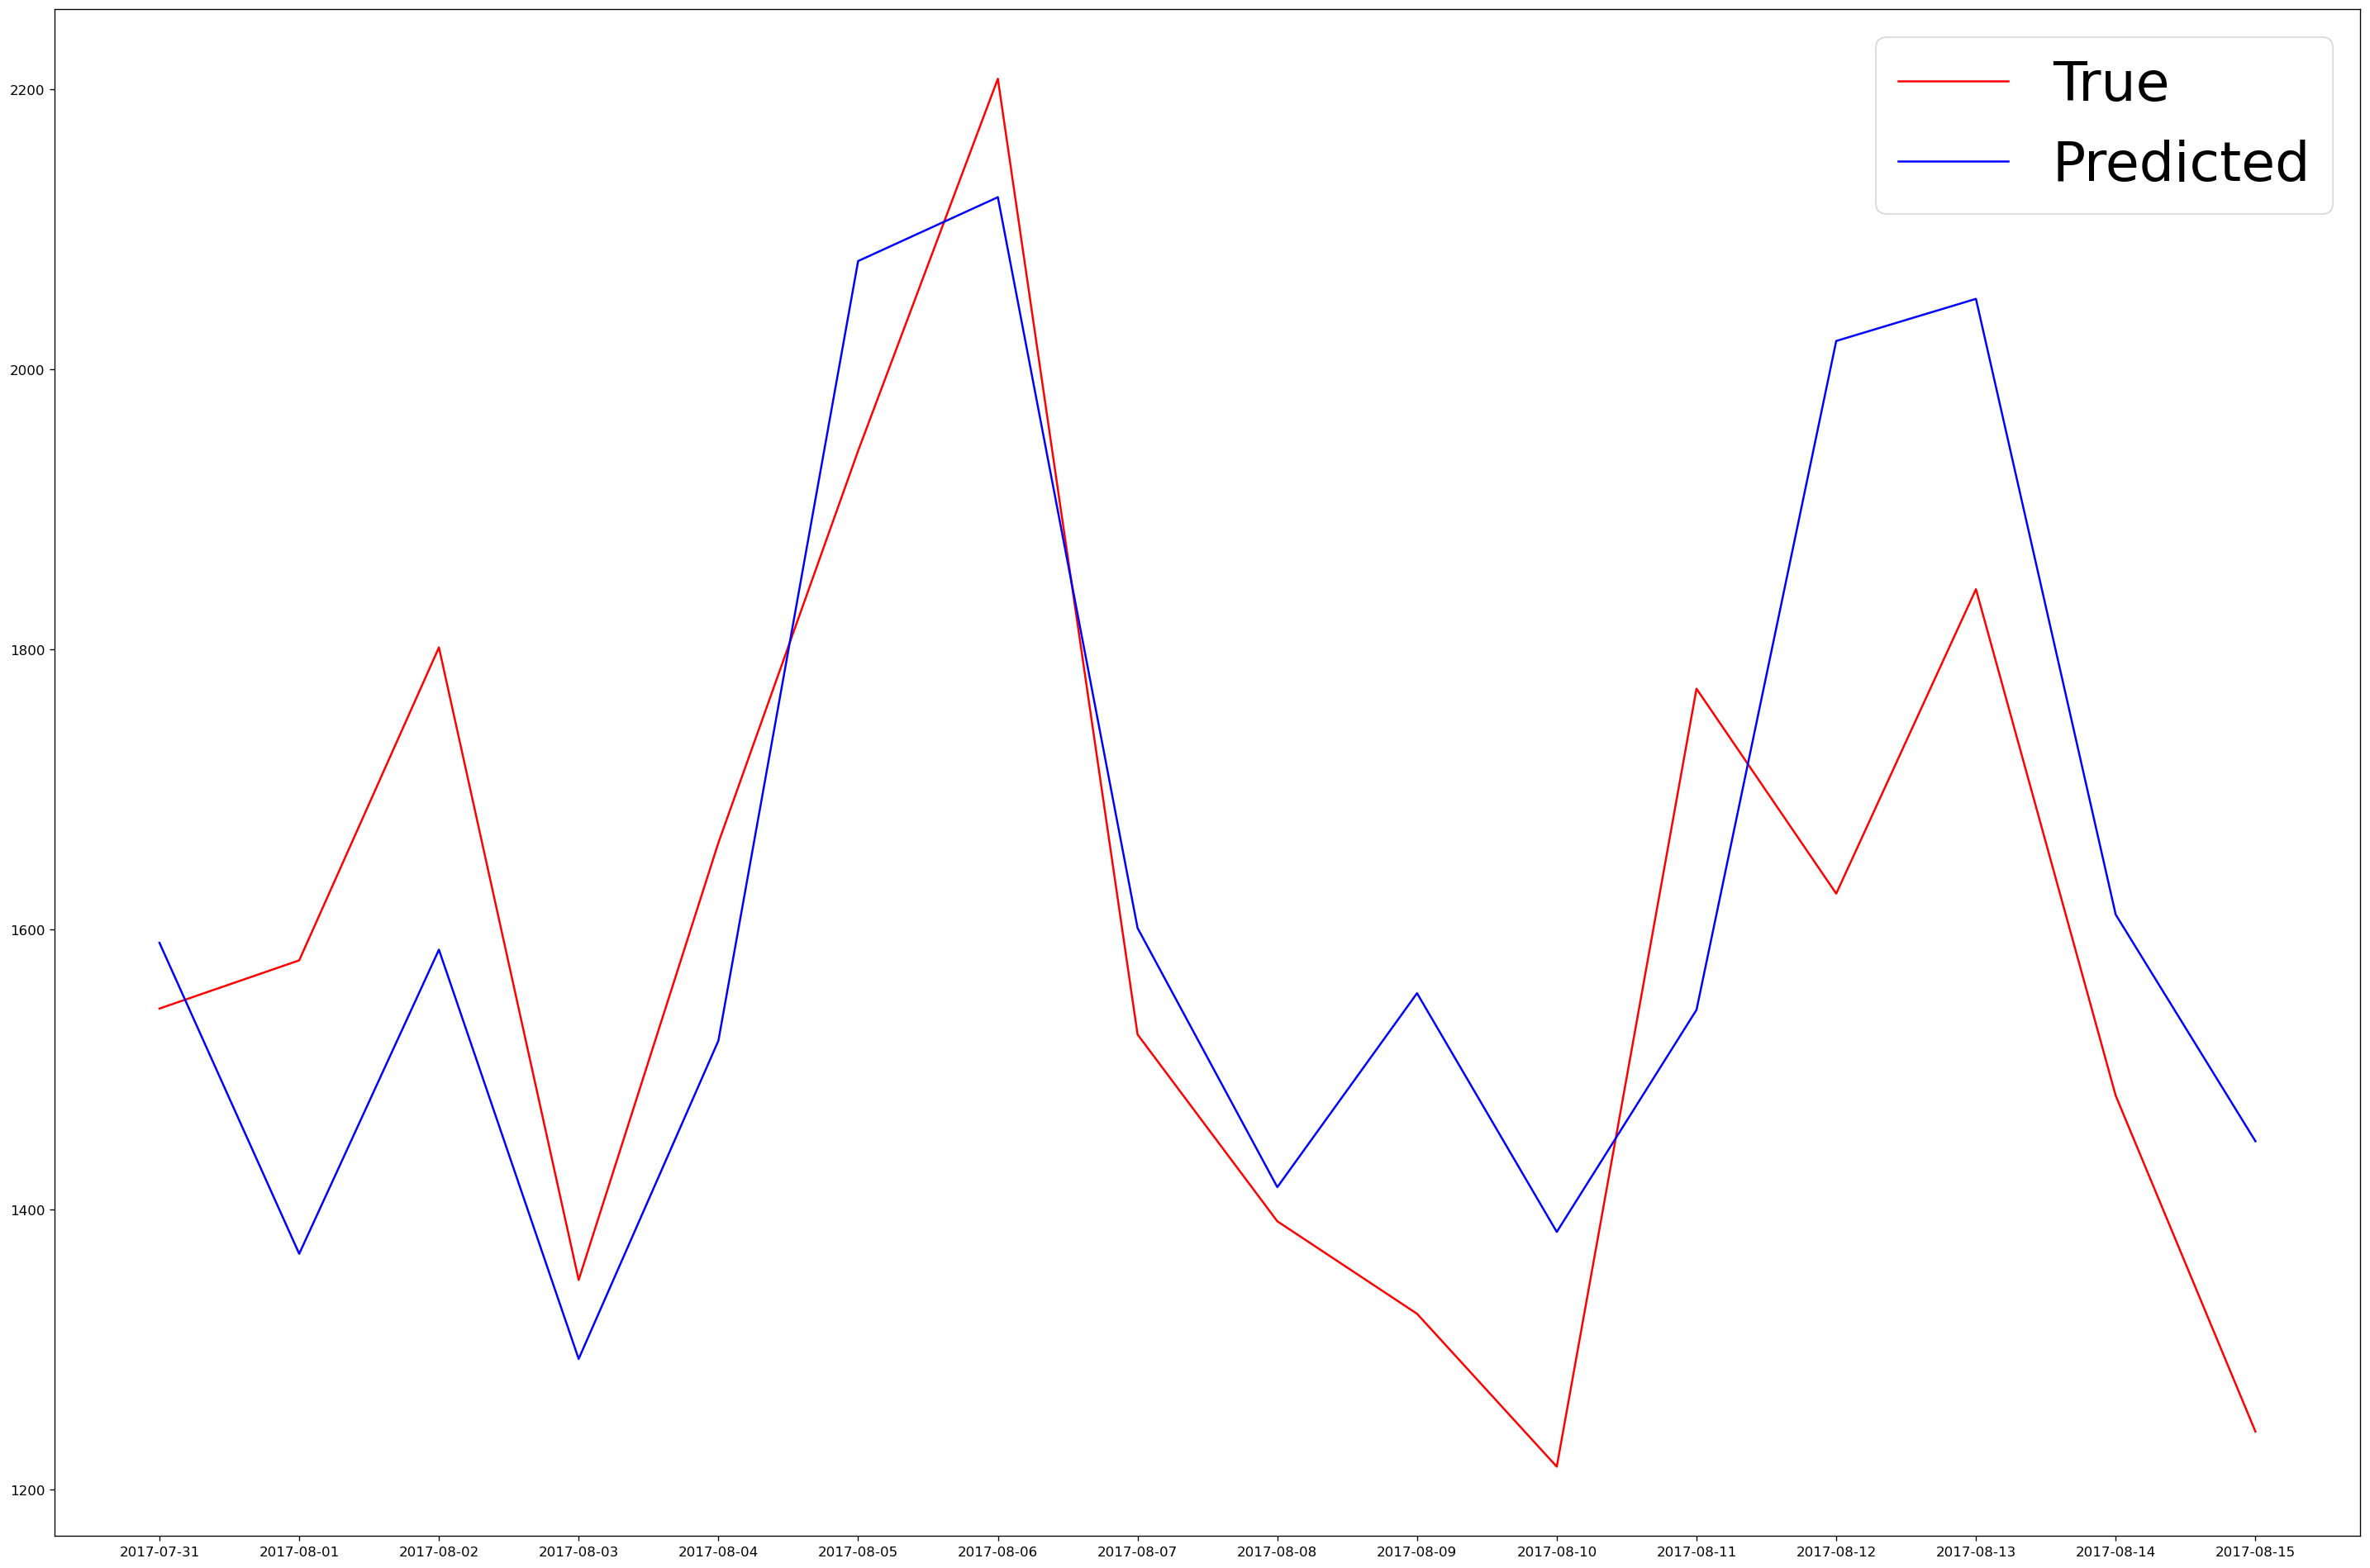

In [165]:
plt.plot(df_test.date, df_test.sales, c='red', label='True')
plt.plot(df_test.date, model_fit.forecast(steps=16), c='blue', label='Predicted')
plt.legend(prop={'size':40})
plt.show()

That's not too bad for a start, but there are definitely lots of things that can be improved.

- - - - - -

<b> Conclusion: </b> 

- Looking into some of the other time series for different families of products in different stores, we have noticed that the variance sometimes changes with time significantly. That is why we decided we could add a GARCH model to account for this.

- Seasonality definitely plays a role in the time series of some of the families of products in some of the stores, so using a SARIMA would also be a good improvement.

Unfortunately due to time constraints, we did not add a GARCH model but we replaced ARIMA with SARIMA and tried to automate the process.